In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "1,2"
from time import time

import FrEIA.framework  as Ff
import FrEIA.modules as Fm

import losses
import monitoring

In [2]:
filename_out    = 'output/inn_per_shape.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1.0e-4
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 25

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_x_features     = 7
ndim_pad_x_features = 593

ndim_y     = 512
ndim_z     = 10
ndim_pad_zy = 78 

# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None

assert ( ndim_x_features + ndim_pad_x_features 
        == ndim_y + ndim_z + ndim_pad_zy), "Dimensions don't match up"

############
#  Losses  #
############

train_forward_mmd    = True
train_backward_mmd   = True
train_reconstruction = False
train_max_likelihood = False

lambd_fit_forw         = 10.
lambd_mmd_forw         = 50.
lambd_reconstruct      = 1.
lambd_mmd_back_class   = 500.
lambd_mmd_back_feature = 50.
lambd_max_likelihood   = 1.

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 5e-2 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 5
#
exponent_clamping = 3.0
#
hidden_layer_sizes = 64
#
use_permutation = True
#
verbose_construction = False

In [3]:
def read_data(path):
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))]
    labels = torch.zeros(len(files), ndim_y, dtype = torch.float32)
    inputs = torch.zeros(len(files), ndim_x_class+ndim_x_features, dtype = torch.float32)
    input_keys = ['shape', 'radius', 'radius_pd','length', 'length_pd',  'volfraction']
    for i,f in enumerate(files):
        with  h5py.File(os.path.join(path,f),'r') as file:
            print(file, end = '\r')
            labels[i,:] = torch.from_numpy(file['entry/I'][()].flatten())#I_noisy
            for i_k, key in enumerate(input_keys):
                try:
                    if key == 'shape':
                        shape = file['properties'][key][()].decode("utf-8")
                        if shape == 'sphere':
                            inputs[i, i_k:i_k+3] = torch.tensor([1,0,0]) 
                            #conditions[i, i+k]
                        elif shape == 'hardsphere':
                            inputs[i, i_k:i_k+3] = torch.tensor([0,1,0])
                        else:
                            inputs[i, i_k:i_k+3] = torch.tensor([0,0,1])
                    elif key =='radius':
                        if shape == 'sphere':
                            inputs[i, i_k+2:i_k+5] = torch.tensor([file['properties'][key][()],0,0]) 
                        elif shape == 'hardsphere':
                            inputs[i, i_k+2:i_k+5] = torch.tensor([0,file['properties'][key][()],0])
                        else:
                            inputs[i, i_k+2:i_k+5] = torch.tensor([0,0,file['properties'][key][()]])
                    else:
                        inputs[i, i_k+4] = file['properties'][key][()]
                except KeyError:
                    # spheres don't have all of the properties a cylinder does
                    pass

    return inputs, labels

In [4]:
inputs,labels = read_data('/home/slaskina/simulations')

In [5]:
def extract_shape(shape):
    if shape == 'sphere':
        return inputs[inputs[:,0]==1][:, 3:], labels[inputs[:,0]==1]
    elif shape == 'hardsphere':
        return inputs[inputs[:,1]==1][:, 3:], labels[inputs[:,1]==1]
    else:
        return inputs[inputs[:,2]==1][:, 3:], labels[inputs[:,2]==1]

In [6]:
def create_loaders(inputs, labels):
    # Creating data indices for training and validation splits:
    dataset_size = len(labels)
    indices = list(range(dataset_size))
    test_size = 0.1
    val_size = 0.2
    test_split = int(np.floor(test_size * dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    np.random.seed(1234)
    np.random.shuffle(indices)
    train_indices, val_indices, test_indices = indices[:dataset_size-test_split-val_split], indices[dataset_size-test_split-val_split:dataset_size-test_split], indices[dataset_size-test_split:]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(inputs, labels), batch_size=batch_size, drop_last=True, sampler = val_sampler)

    train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(inputs, labels), batch_size=batch_size, drop_last=True, sampler = train_sampler)

    return train_indices, val_indices, test_indices,  test_loader, train_loader

In [7]:
def subnet2(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))


def subnet1(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes*2), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes*2,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))


input = Ff.InputNode(ndim_x_features + ndim_pad_x_features, name='input_features')

nodes = [input]
for i in range(N_blocks):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet2, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))
    if use_permutation:
        nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':i}, name='permute_{}'.format(i)))

nodes.append(Ff.OutputNode([nodes[-1].out0], name='output'))
model_sphere = Ff.GraphINN(nodes, verbose=verbose_construction)
model_sphere.to(device)

model_hardsphere = Ff.GraphINN(nodes, verbose=verbose_construction)
model_hardsphere.to(device)

model_cylinder = Ff.GraphINN(nodes, verbose=verbose_construction)
model_cylinder.to(device)


GraphINN(
  (module_list): ModuleList(
    (0): RNVPCouplingBlock(
      (subnet_s1): Sequential(
        (0): Linear(in_features=300, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): Linear(in_features=64, out_features=300, bias=True)
      )
      (subnet_t1): Sequential(
        (0): Linear(in_features=300, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): Linear(in_features=64, out_features=300, bias=True)
      )
      (subnet_s2): Sequential(
        (0): Linear(in_features=300, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): Linear(in_features=64, out_features=300, bias=True)
      )
      (subnet_t2): Sequential(
        (0): Linear(in_features=300, out_features=64, bias=True)
        (1): ReLU(

In [8]:
def params_trainable(model):
    params_trainable = list(filter(lambda p: p.requires_grad, model.parameters()))
    for p in params_trainable:
        p.data = init_scale * torch.randn(p.data.shape).to(device)
    return params_trainable

def optimizer(model):
    optim = torch.optim.Adam(params_trainable(model), lr=lr_init, betas=adam_betas, eps=1e-6, weight_decay=l2_weight_reg)
    return optim 

gamma = (final_decay)**(1./n_epochs)

def optim_step(optim):
    #for p in params_trainable:
        #print(torch.mean(torch.abs(p.grad.data)).item())
    optim.step()
    optim.zero_grad()

def save(name, model, optim):
    torch.save({'opt':optim.state_dict(),
                'net':model.state_dict()}, name)

def load(name, model, optim):
    state_dicts = torch.load(name)
    model.load_state_dict(state_dicts['net'])
    try:
        optim.load_state_dict(state_dicts['opt'])
    except ValueError:
        print('Cannot load optimizer for some reason or other')

In [34]:

def noise_batch(ndim):
    return torch.randn(batch_size, ndim).to(device)


def loss_forward_mmd(out, y):
    # Shorten output, and remove gradients wrt y, for latent loss
    # [z,y] only
    output_block_grad = torch.cat((out[:, :ndim_z],
                                   out[:, -ndim_y:].data), dim=1) 
    y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)

    l_forw_fit = lambd_fit_forw * losses.l2_fit(out[:, ndim_z:], y[:, ndim_z:])
    l_forw_mmd = lambd_mmd_forw  * torch.mean(losses.forward_mmd(output_block_grad, y_short))

    return l_forw_fit, l_forw_mmd

def loss_backward_mmd(model,  x, y):
    x_sampled, x_samples_jac = model(y, rev=True, jac = False) 
    MMD_features = losses.backward_mmd(x, x_sampled)
    if mmd_back_weighted:
        MMD_features *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(y, y))
    return lambd_mmd_back_feature * torch.mean(MMD_features)


def loss_reconstruction(model, out_y, x):
    cat_inputs = [out_y[:, :ndim_z] + add_z_noise * noise_batch(ndim_z)] # list with 1 tensor
    
    if ndim_pad_zy:
        cat_inputs.append(out_y[:, ndim_z:-ndim_y] + add_pad_noise * noise_batch(ndim_pad_zy)) # list with 2 tensor
    cat_inputs.append(out_y[:, -ndim_y:] + add_y_noise * noise_batch(ndim_y)) # list with 3 tensors
    x_reconstructed_features, x_reconstructed_jac = model(torch.cat(cat_inputs, 1), rev=True) # concatenate list elements along axis 1
    return lambd_reconstruct * losses.l2_fit(x_reconstructed_features, x) # needs fix

def train_epoch(model, optim, i_epoch, loader, test=False):
    if not test:
        model.train()
        loader = loader

    if test:
        model.eval()
        loader = loader
        nograd = torch.no_grad()
        nograd.__enter__()


    batch_idx = 0
    loss_history = []

    for x, y in loader:

        if batch_idx > n_its_per_epoch:
            break
        batch_losses = []

        batch_idx += 1

        #x, y = Variable(x).to(device), Variable(y).to(device)
        x, y = x.to(device), y.to(device)

        if add_y_noise > 0:
            y += add_y_noise * noise_batch(ndim_y)

        if ndim_pad_x_features:
            x = torch.cat((x, add_pad_noise * noise_batch(ndim_pad_x_features)), dim=1)

        if ndim_pad_zy:
            y = torch.cat((add_pad_noise * noise_batch(ndim_pad_zy), y), dim=1)
        # y = [z, pad_yz, y]
        y = torch.cat((noise_batch(ndim_z), y), dim=1)
        out_y, out_y_jac = model(x, jac  = False)
        # tuple with output[0] and jacobian[1]

        if train_forward_mmd:
            batch_losses.extend(loss_forward_mmd(out_y, y))

        if train_backward_mmd:
            batch_losses.append(loss_backward_mmd(model, x, y))

        if train_reconstruction:
            batch_losses.append(loss_reconstruction(model, out_y.data, x))

        l_total = sum(batch_losses)
        loss_history.append([l.item() for l in batch_losses]) # lisr of lists: list for each batch
        print(loss_history)
        if not test:
            l_total.backward()
            optim_step(optim)

    if test:
        monitoring.show_hist(out_y[:, :ndim_z])
        monitoring.show_cov(out_y[:, :ndim_z])
        if test_time_functions:
            out_x, out_x_jac = model(y, rev=True, jac = False) 
            for f in test_time_functions:
                f( out_x, out_y, x, y)

        nograd.__exit__(None, None, None)
    return np.mean(loss_history, axis=0)

def train(model, optim, train_loader, test_loader):
    monitoring.restart()

    try:
        monitoring.print_config()
        t_start = time()
        for i_epoch in range(-pre_low_lr, n_epochs):

            if i_epoch < 0:
                for param_group in optim.param_groups:
                    param_group['lr'] = lr_init * 1e-1

            train_losses = train_epoch(model,optim,  i_epoch, train_loader) # mean over batches
            test_losses  = train_epoch(model, None, i_epoch, test_loader,  test=True)
            t = np.concatenate([train_losses, test_losses])
            monitoring.show_loss(t)

    except:
        save( filename_out + '_ABORT',model, optim)
        raise

    finally:
        print("\n\nTraining took %f minutes\n\n" % ((time()-t_start)/60.))
        save( filename_out,model, optim)


In [10]:
def make_prediction(labels, model):
    y = torch.cat((add_pad_noise * torch.randn( len(labels), ndim_pad_zy).to('cuda'), labels.to('cuda')), dim=1)
    y = torch.cat((torch.randn( len(labels), ndim_z).to('cuda'), y), dim=1)
    pred_features, _ = model(y, rev = True)  # output of NN without padding
    return pred_features.cpu().detach()[:, :ndim_x_features]

In [11]:
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes, create_table_from_outcome
import seaborn as sns

In [12]:
def violinplot_feature_shape(df_test,  sampled_inputs, feature):
    """
    Feature is either shape name, which will yield the radius
    or the one of the keys in the `indexer`.
    """
    indexer = {'radius_pd'   :3,
                'length'     :4,
                'length_pd'  :5,
                'volfraction':6}
    if feature =='sphere':
        pred = df_test[:, 0]
        sampled = sampled_inputs[:, 0]
    elif feature == 'hardsphere':
        pred = df_test[:, 1]
        sampled = sampled_inputs[:, 1]
    elif feature == 'cylinder':
        pred = df_test[:, 2]
        sampled = sampled_inputs[:, 2]
    else:
        pred = df_test[:, indexer[feature]]
        sampled = sampled_inputs[:, indexer[feature]]
    df = pd.concat([pd.DataFrame({'value': sampled, 'feature':'sampled'}),pd.DataFrame({'value': pred, 'feature':'predicted'})])
    sns.violinplot(df, y = 'value', x = 'feature') # can't generalize

## Sphere

In [13]:
inputs_sphere,labels_sphere =  extract_shape('sphere')

In [14]:
train_indices_sphere, val_indices_sphere, test_indices_sphere,  test_loader_sphere, train_loader_sphere = create_loaders(inputs_sphere,labels_sphere)

In [35]:
train(model_sphere, optimizer(model_sphere),  train_loader_sphere, test_loader_sphere)

Config options:

  N_blocks                 	5
  adam_betas               	(0.9, 0.95)
  add_pad_noise            	0.01
  add_y_noise              	0.05
  add_z_noise              	0.02
  batch_size               	256
  device                   	cuda
  exponent_clamping        	3.0
  filename_in              	
  filename_out             	output/my_inn.pt
  final_decay              	0.02
  hidden_layer_sizes       	16
  init_scale               	0.1
  interactive_visualization	False
  l2_weight_reg            	1e-05
  lambd_fit_forw           	10.0
  lambd_max_likelihood     	1.0
  lambd_mmd_back_class     	500.0
  lambd_mmd_back_feature   	50.0
  lambd_mmd_forw           	50.0
  lambd_reconstruct        	1.0
  lr_init                  	0.001
  mmd_back_kernels         	[(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
  mmd_back_weighted        	True
  mmd_forw_kernels         	[(0.2, 2), (1.5, 2), (3.0, 2)]
  n_epochs                 	25
  n_its_per_epoch          	200
  ndim_pad_x_class         	39

KeyboardInterrupt: 

In [16]:
df_test = make_prediction(labels[test_indices_sphere], model_sphere)

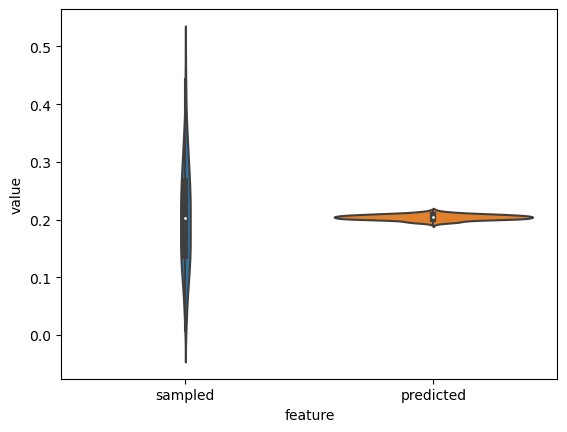

In [17]:
violinplot_feature_shape(df_test, inputs_sphere[test_indices_sphere], 'sphere')

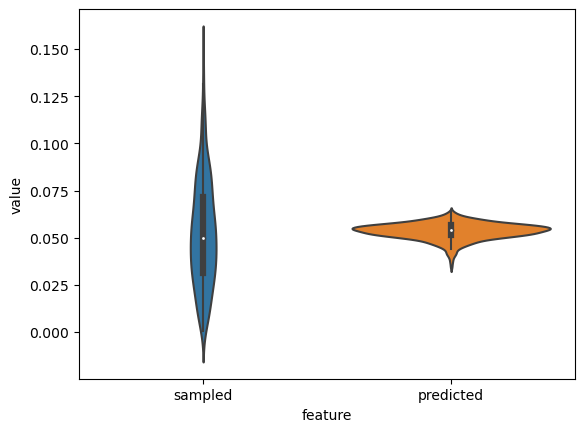

In [18]:
violinplot_feature_shape(df_test, inputs_sphere[test_indices_sphere], 'radius_pd')

## Hardsphere

In [21]:
inputs_hardsphere,labels_hardsphere =  extract_shape('hardsphere')
train_indices_hardsphere, val_indices_hardsphere, test_indices_hardsphere,  test_loader_hardsphere, train_loader_hardsphere = create_loaders(inputs_hardsphere,labels_hardsphere)
train(model_hardsphere, optimizer(model_hardsphere),train_loader_hardsphere, test_loader_hardsphere)

Config options:

  N_blocks                 	5
  adam_betas               	(0.9, 0.95)
  add_pad_noise            	0.01
  add_y_noise              	0.05
  add_z_noise              	0.02
  batch_size               	256
  device                   	cuda
  exponent_clamping        	3.0
  filename_in              	
  filename_out             	output/my_inn.pt
  final_decay              	0.02
  hidden_layer_sizes       	16
  init_scale               	0.1
  interactive_visualization	False
  l2_weight_reg            	1e-05
  lambd_fit_forw           	10.0
  lambd_max_likelihood     	1.0
  lambd_mmd_back_class     	500.0
  lambd_mmd_back_feature   	50.0
  lambd_mmd_forw           	50.0
  lambd_reconstruct        	1.0
  lr_init                  	0.001
  mmd_back_kernels         	[(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
  mmd_back_weighted        	True
  mmd_forw_kernels         	[(0.2, 2), (1.5, 2), (3.0, 2)]
  n_epochs                 	25
  n_its_per_epoch          	200
  ndim_pad_x_class         	39

In [22]:
df_test = make_prediction(labels[test_indices_hardsphere], model_hardsphere)

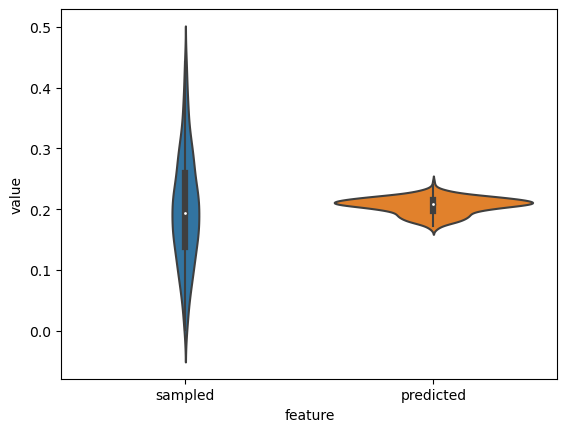

In [23]:
violinplot_feature_shape(df_test, inputs_hardsphere[test_indices_hardsphere], 'hardsphere')

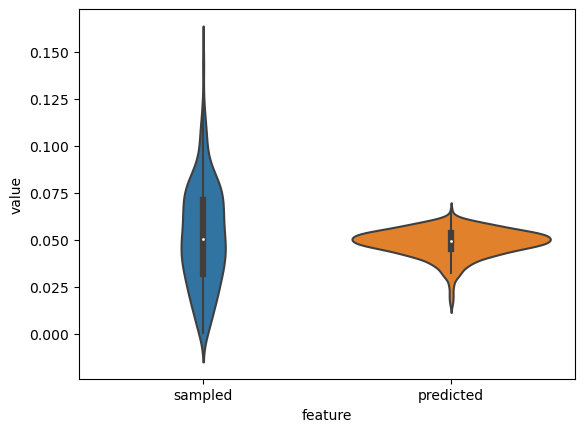

In [24]:
violinplot_feature_shape(df_test, inputs_hardsphere[test_indices_hardsphere], 'radius_pd')

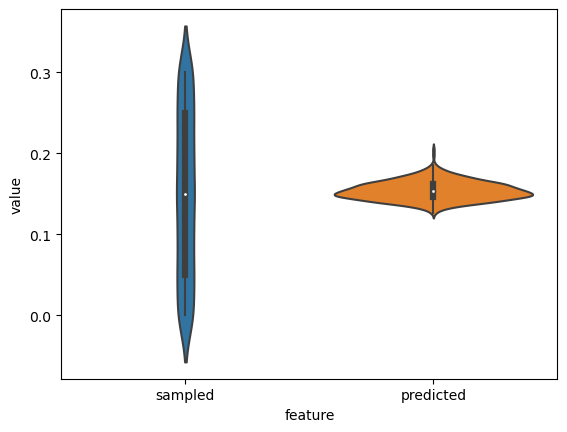

In [25]:
violinplot_feature_shape(df_test, inputs_hardsphere[test_indices_hardsphere], 'volfraction')

## Cylinder

In [28]:
inputs_cylinder,labels_cylinder =  extract_shape('cylinder')
train_indices_cylinder, val_indices_cylinder, test_indices_cylinder,  test_loader_cylinder, train_loader_cylinder = create_loaders(inputs_cylinder,labels_cylinder)
train(model_cylinder, optimizer(model_cylinder),train_loader_cylinder, test_loader_cylinder)

Config options:

  N_blocks                 	5
  adam_betas               	(0.9, 0.95)
  add_pad_noise            	0.01
  add_y_noise              	0.05
  add_z_noise              	0.02
  batch_size               	256
  device                   	cuda
  exponent_clamping        	3.0
  filename_in              	
  filename_out             	output/my_inn.pt
  final_decay              	0.02
  hidden_layer_sizes       	16
  init_scale               	0.1
  interactive_visualization	False
  l2_weight_reg            	1e-05
  lambd_fit_forw           	10.0
  lambd_max_likelihood     	1.0
  lambd_mmd_back_class     	500.0
  lambd_mmd_back_feature   	50.0
  lambd_mmd_forw           	50.0
  lambd_reconstruct        	1.0
  lr_init                  	0.001
  mmd_back_kernels         	[(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
  mmd_back_weighted        	True
  mmd_forw_kernels         	[(0.2, 2), (1.5, 2), (3.0, 2)]
  n_epochs                 	25
  n_its_per_epoch          	200
  ndim_pad_x_class         	39

In [29]:
df_test = make_prediction(labels[test_indices_cylinder], model_cylinder)

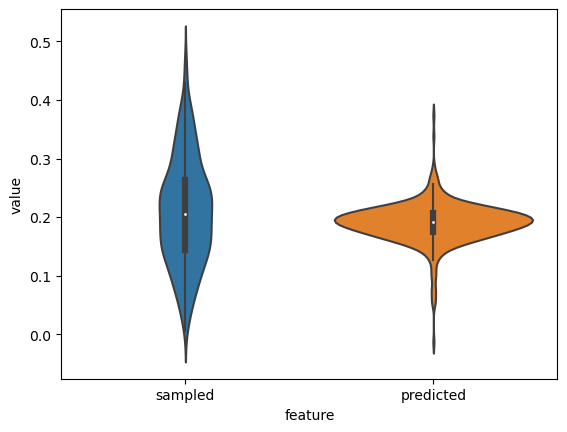

In [30]:
violinplot_feature_shape(df_test, inputs_cylinder[test_indices_cylinder], 'cylinder')

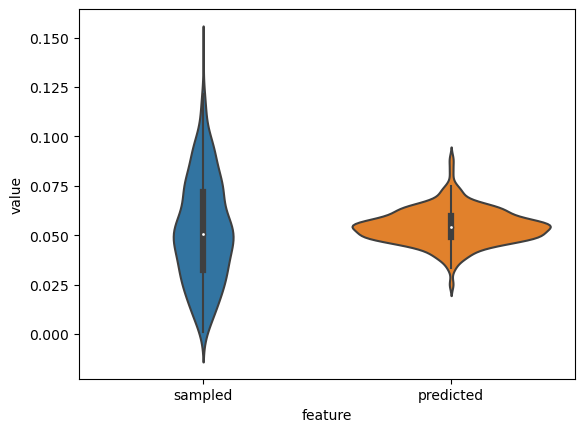

In [31]:
violinplot_feature_shape(df_test, inputs_cylinder[test_indices_cylinder], 'radius_pd')

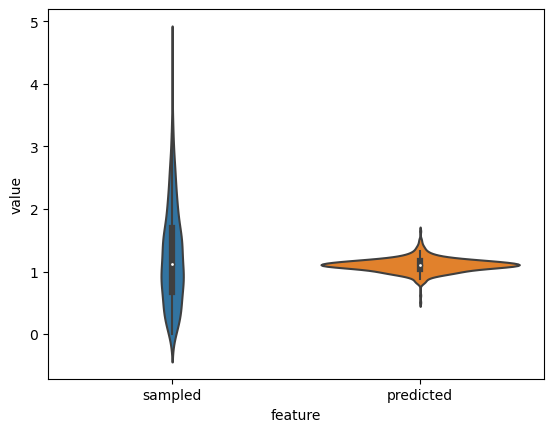

In [32]:
violinplot_feature_shape(df_test, inputs_cylinder[test_indices_cylinder], 'length')

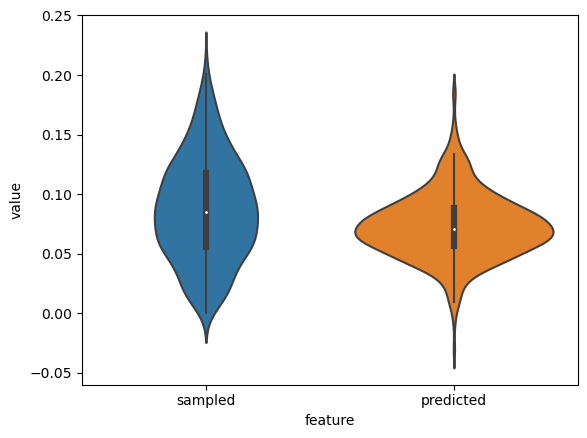

In [33]:
violinplot_feature_shape(df_test, inputs_cylinder[test_indices_cylinder], 'length_pd')